In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^GSPC'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(14951, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1965-01-04,84.459999,85.150002,83.769997,84.230003,84.230003,4.433551,0.997277,1.004749,1.004749
1965-01-05,84.629997,85.019997,84.019997,84.629997,84.629997,4.438289,1.000000,1.003072,1.003072
1965-01-06,84.889999,85.379997,84.449997,84.889999,84.889999,4.441356,1.000000,1.004359,1.004359
1965-01-07,85.260002,85.620003,84.660004,85.260002,85.260002,4.445705,1.000000,1.001290,1.001290
1965-01-08,85.370003,85.839996,84.910004,85.370003,85.370003,4.446995,1.000000,1.000351,1.000351
1965-01-11,85.400002,85.809998,84.900002,85.400002,85.400002,4.447346,1.000000,1.002459,1.002459
1965-01-12,85.610001,85.980003,85.129997,85.610001,85.610001,4.449802,1.000000,1.002687,1.002687
1965-01-13,85.839996,86.269997,85.349998,85.839996,85.839996,4.452485,1.000000,1.000000,1.000000
1965-01-14,85.839996,86.379997,85.410004,85.839996,85.839996,4.452485,1.000000,1.004310,1.004310


In [3]:
SIM_START = pd.to_datetime('1983-01-04')  # first day of legit open/close values
SIM_START

Timestamp('1983-01-04 00:00:00')

In [4]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False])}

In [5]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q}

In [6]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

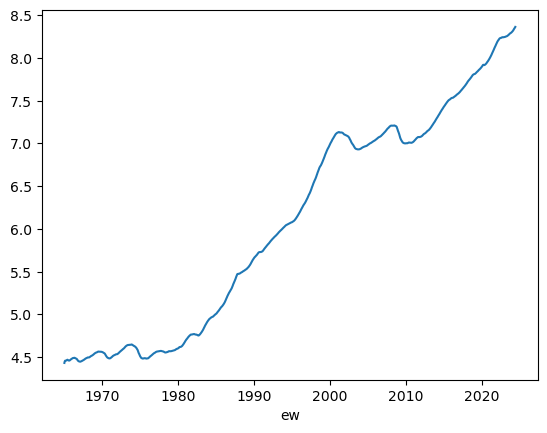

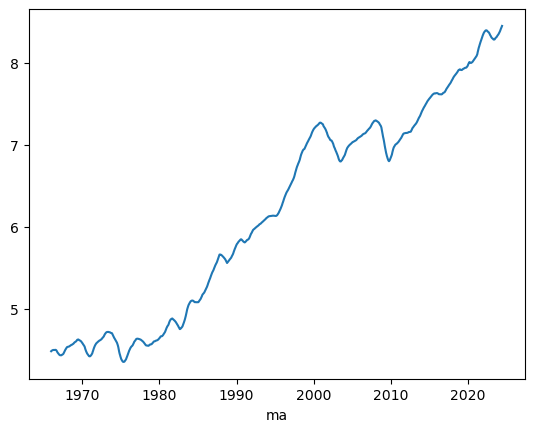

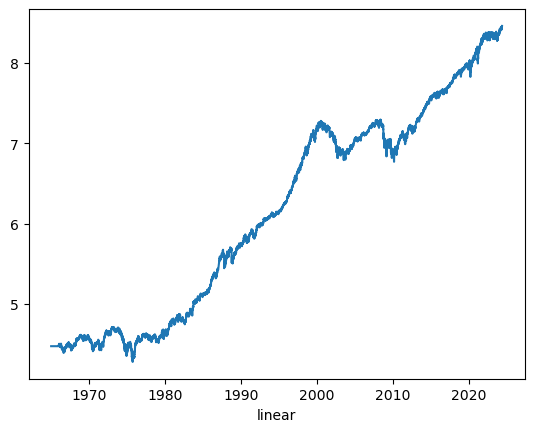

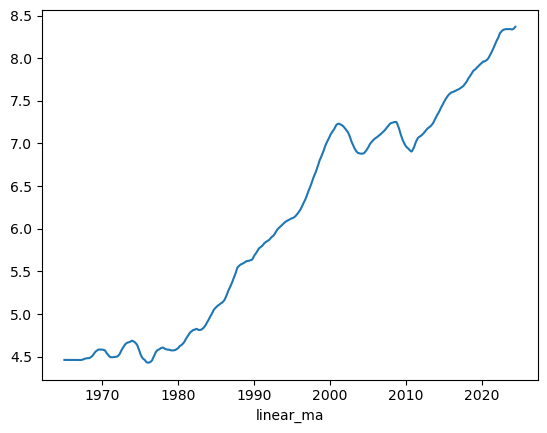

In [7]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [8]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [9]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [10]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [11]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    df['amt_in'] = bounded_sigmoid(
        df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [12]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [13]:
with open(PARAM_PATH, 'rb') as f:
    current_best, best_params = pickle.load(f)
current_best, best_params

(78.27899058517231,
 {'time_param': 29,
  'method': 'ma',
  't': 0.8163020046569786,
  'k': 8.234747712553325,
  'as_q': True})

In [14]:
# Temp
#current_best = None
#best_params = None

Do nothing res: 37.52631714728002
Round 1: 78.27899058517231
New best: 78.27899058517231
{'time_param': 29, 'method': 'ma', 't': 0.8163020046569786, 'k': 8.234747712553325, 'as_q': True}


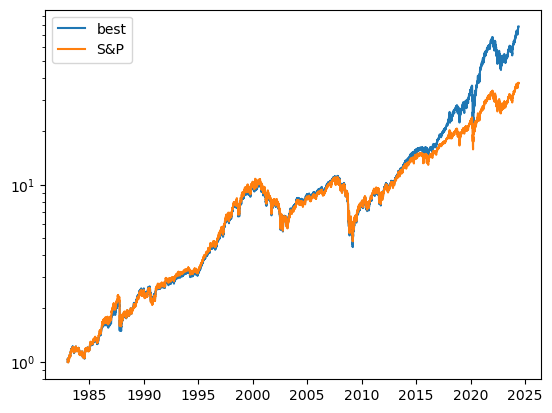

Round 2: 2.411452584981262
Round 3: 26.080436721299634
Round 4: 3.9104687514848124
Round 5: 58.57165976165952
Round 6: 16.70841582166295
Round 7: 65.3089079066949
Round 8: 1.4106275437337583
Round 9: 41.38151853209216
Round 10: 60.15126272716574
Round 11: 1.505245524834772
Round 12: 2.224484544136824
Round 13: 1.1360506832543396
Round 14: 2.9238473702996663
Round 15: 6.1453895829078995
Round 16: 65.6513785694559
Round 17: 1.67055629792849
Round 18: 23.663486316908
Round 19: 2.1491043436727635
Round 20: 29.260574288502106
Round 21: 15.109064787148748
Round 22: 48.51516688464243
Round 23: 7.383392088211227
Round 24: 1.803582516488614
Round 25: 41.80207761329839
Round 26: 7.290903642591979
Round 27: 1.4722097266503726
Round 28: 1.3872931075388293
Round 29: 62.86447892673918
Round 30: 16.408764545716785
Round 31: 14.19128929274974
Round 32: 12.838446411114088
Round 33: 48.671172660916696
Round 34: 1.2441856109364708
Round 35: 58.87696682836127
Round 36: 38.62777238247327
Round 37: 62.71321

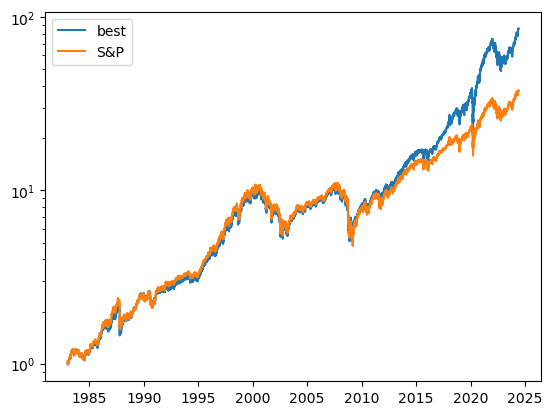

Round 69: 60.399547760686815
Round 70: 50.5546611799888
Round 71: 5.681102654591254
Round 72: 26.04064535248996
Round 73: 3.5108986552085444
Round 74: 4.894954376782842
Round 75: 31.46284785382634
Round 76: 5.914001107924212
Round 77: 64.74229674015831
Round 78: 36.746688154488794
Round 79: 1.3813881189410704
Round 80: 16.98547543477487
Round 81: 2.409889321032303
Round 82: 1.8661542256850971
Round 83: 29.784568214967834
Round 84: 6.694225921179793
Round 85: 3.5086873978628037
Round 86: 1.360502437182289
Round 87: 4.817217345346544
Round 88: 45.38216910195374
Round 89: 2.0205745854122172
Round 90: 2.3706001279680913
Round 91: 1.8115737747842187
Round 92: 4.230196534049275
Round 93: 3.91522583566642
Round 94: 1.3292038324977915
Round 95: 50.65947735121956
Round 96: 1.8191154571358223
Round 97: 52.73608319585975
Round 98: 7.115567017875301
Round 99: 2.357430331256209
Round 100: 53.11832276596247


In [15]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 37.52631714728002
Round 1: 78.31704343237223
Round 2: 63.3447583713787
Round 3: 72.85382420843152
Round 4: 63.34468697933088
Round 5: 87.53783479236569
New best: 87.53783479236569
{'time_param': 11, 'method': 'ma', 't': 0.45068290939207833, 'k': 9.308146692535553, 'as_q': True}


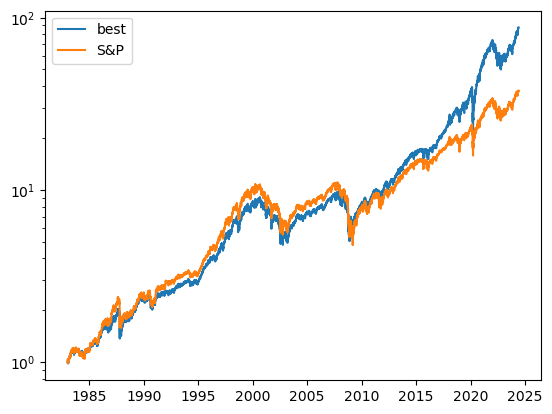

Round 6: 75.52887071751613
Round 7: 90.69665898957703
New best: 90.69665898957703
{'time_param': 10, 'method': 'ma', 't': 0.6315130397138617, 'k': 9.196802044483523, 'as_q': True}


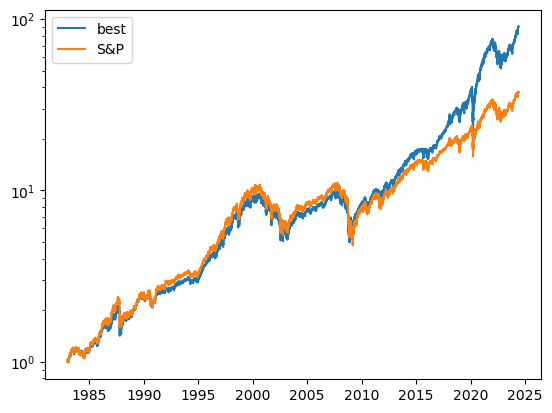

Round 8: 87.90850395071689
Round 9: 88.27089955513452
Round 10: 89.2671661570511
Round 11: 87.28069863688661
Round 12: 83.10961481638876
Round 13: 86.6928174119664
Round 14: 89.32443859824444
Round 15: 88.02677459727366
Round 16: 79.44122873156884
Round 17: 89.20849774071556
Round 18: 83.96496651505996
Round 19: 88.6970987187884
Round 20: 82.38381833969183
Round 21: 63.34379211277131
Round 22: 81.26406017801068
Round 23: 63.343799348099076
Round 24: 80.80175261478442
Round 25: 79.90203890473468

Factor: 1.03125
Do nothing res: 37.52631714728002
Round 1: 83.63988719832739
Round 2: 85.12338618477656
Round 3: 63.34334703380614
Round 4: 89.40591113784711
Round 5: 89.39319081222328
Round 6: 86.12727125549857
Round 7: 86.37084869057504
Round 8: 87.52302275168691
Round 9: 85.69764652388092
Round 10: 83.15564087327714
Round 11: 21.351787689586324
Round 12: 83.35710630045371
Round 13: 63.343598912609714
Round 14: 87.22577173084838
Round 15: 84.34229471576128
Round 16: 89.09636317289623
Round 17

In [16]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [17]:
final_out = simulate(df, params_out)

In [18]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999542600197463

In [19]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.48651362023960915

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


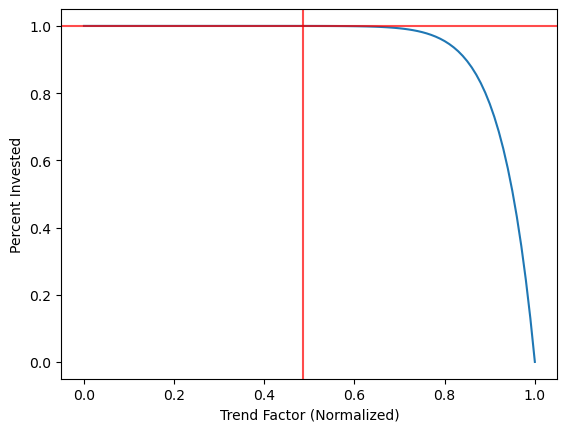

In [20]:
xs = np.linspace(0, 1, 101)
ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

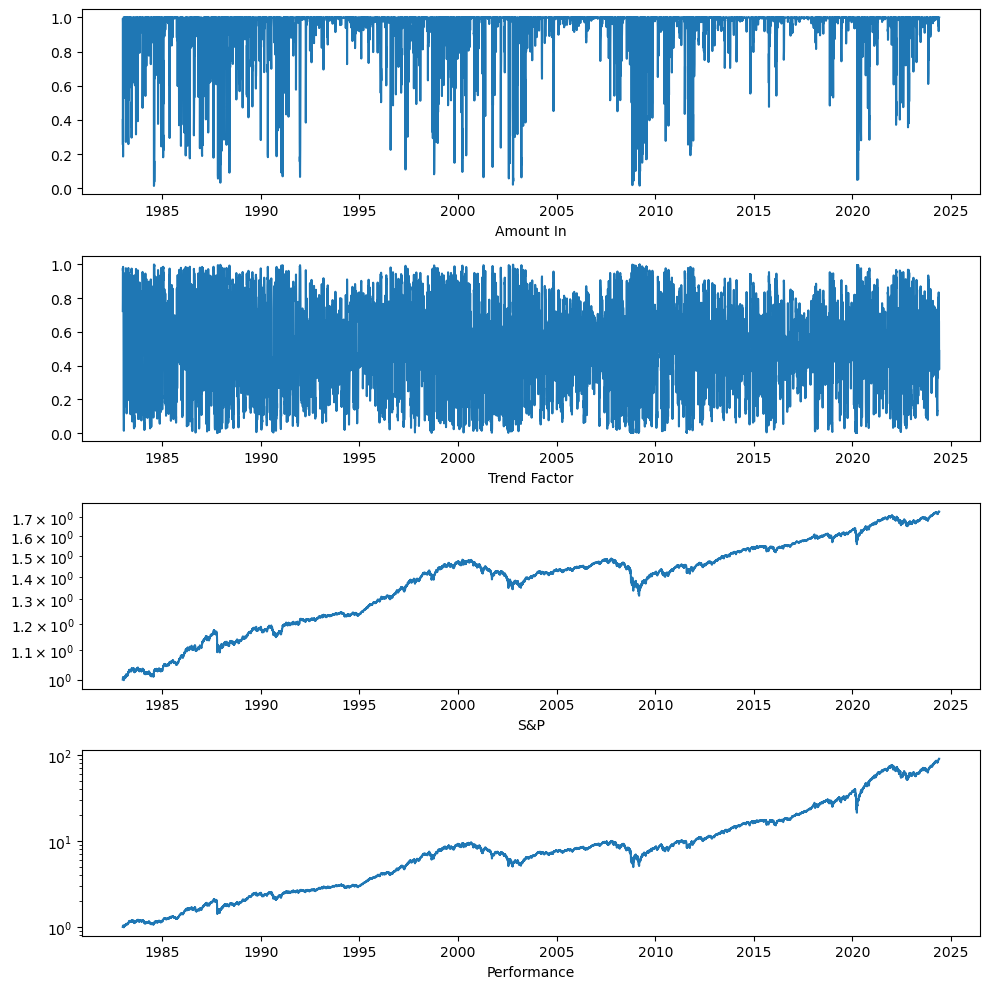

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('S&P')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [22]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('S&P')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

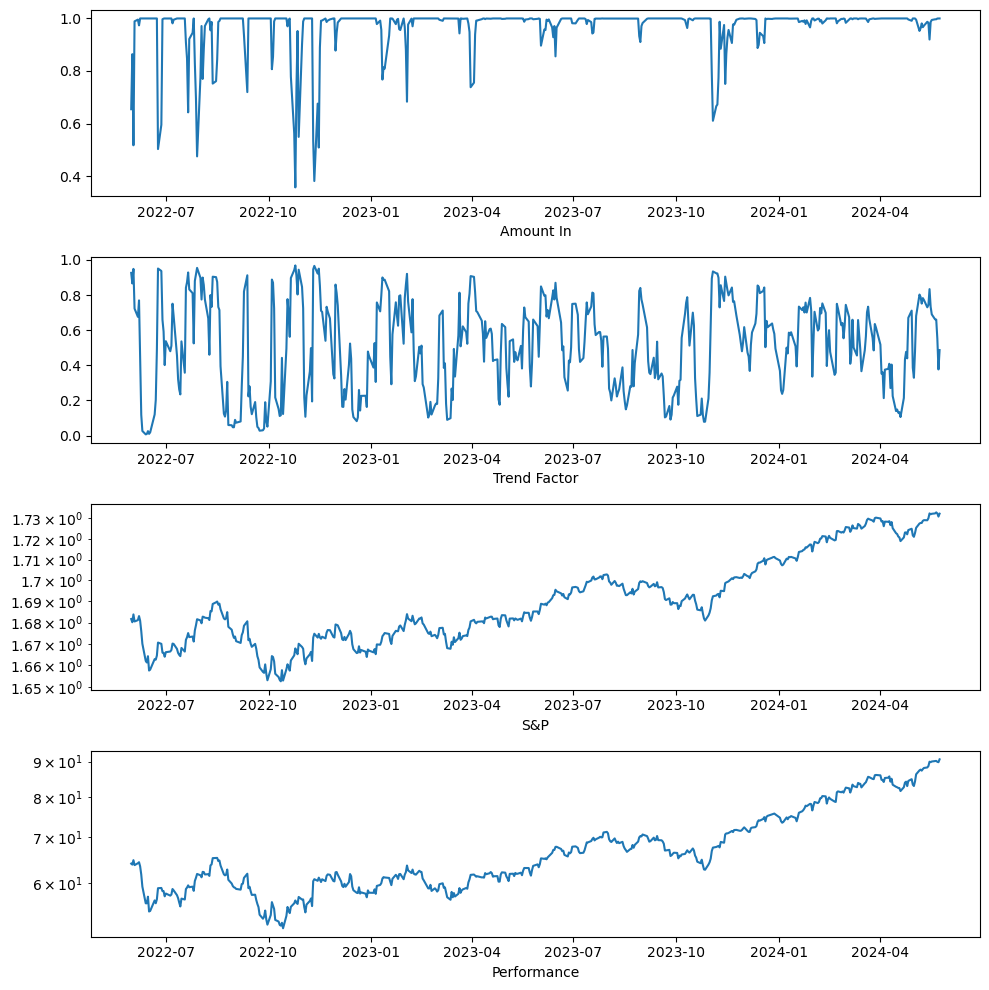

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('S&P')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [24]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(90.69665898957703,
 {'time_param': 10,
  'method': 'ma',
  't': 0.6315130397138617,
  'k': 9.196802044483523,
  'as_q': True})

In [25]:
round(final_out['amt_in'][-1], 4)

1.0